# SVM no DOLFUT

**Etapas**<br>
<br>
• Passo 0  - Assistir aulas anteriores <br>
• Passo 1  - Carregar bibiotecas<br>
• Passo 2  - Carregar base de dados<br>
• Passo 3  - Tratamento de dados<br>
• Passo 4  - Contrução de alvos e variáveis<br>
• Passo 5  - Preparação da base para treinamento e teste<br>
• Passo 6  - Treinamento do modelo<br>
• Passo 7  - Avaliação de resultados<br>
• Passo 8  - Otimização com Grid Search<br>
• Passo 9  - Treinamento com modelo otimizado<br>
• Passo 10 - Ensemble simples<br>

In [39]:
import pandas as pd
import numpy as np
import time
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, precision_recall_curve, auc, make_scorer, recall_score
import statsmodels.api as sm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import os
os.chdir('C:\\Users\\dalto\\OpM na Prática\\Python\\Base de Dados')

df = pd.read_csv("WDOFUT.csv", sep = ";")

In [4]:
df

,Data,Abertura,Maxima,Minima,Fechamento
0,17/05/2005,2487.0,2502.0,2487.0,2494.0
1,18/05/2005,2484.0,2484.0,2469.0,2470.0
2,19/05/2005,2455.0,2458.0,2450.0,2455.0
3,20/05/2005,2460.0,2463.0,2451.0,2451.0
4,23/05/2005,2443.0,2443.0,2432.0,2433.0
...,...,...,...,...,...
3849,09/12/2020,5100.5,5198.0,5087.0,5172.5
3850,10/12/2020,5112.0,5133.0,5016.0,5027.5
3851,11/12/2020,5055.0,5089.0,5029.5,5070.5
3852,14/12/2020,5039.0,5131.0,5010.5,5117.5


In [5]:
df["Data"] = pd.to_datetime(df["Data"]).dt.normalize()
df = df.set_index("Data")

In [6]:
df.describe()

,Abertura,Maxima,Minima,Fechamento
count,3854.000000,3854.000000,3854.000000,3854.000000
mean,2695.424453,2714.421069,2677.683342,2695.850519
std,996.551114,1006.839596,986.645656,997.148535
min,1534.500000,1542.000000,1530.000000,1541.500000
25%,1910.000000,1921.375000,1896.250000,1909.125000
50%,2275.500000,2292.750000,2260.000000,2274.750000
75%,3312.125000,3333.000000,3292.750000,3313.750000
max,5927.500000,5977.500000,5823.500000,5894.500000


In [7]:
per = 1

df["Lag"] = df["Fechamento"].shift(-per)

df["Retorno"] = df["Fechamento"].pct_change(per)
df["Alvo"] = df["Retorno"].shift(-per)

df["Pontos"] = (df["Fechamento"] - df["Fechamento"].shift(1))
df["Pontos"] = df["Pontos"].shift(-per)

In [8]:
df["Retorno"].describe()

count    3853.000000
mean        0.000246
std         0.011053
min        -0.079897
25%        -0.005851
50%         0.000000
75%         0.005831
max         0.078145
Name: Retorno, dtype: float64

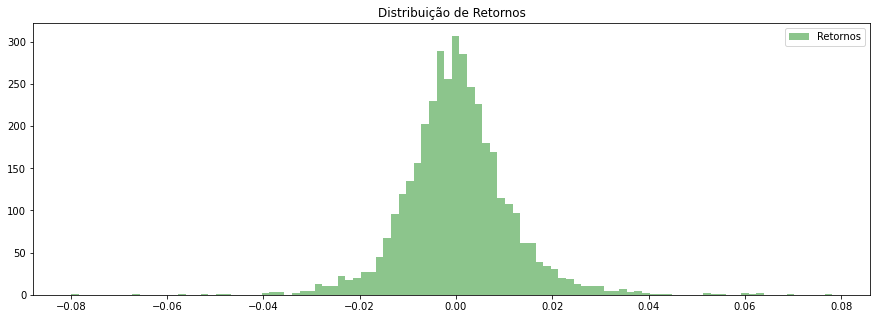

In [9]:
plt.figure(figsize = (15,5))
plt.hist(df["Retorno"], bins = 100
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "g"
        , edgecolor = "none"
        , label = "Retornos")

plt.legend()
plt.title("Distribuição de Retornos");

In [10]:
# Criando alvo, divide em 3 partes 
df["AlvoBin"] = np.where(df["Alvo"] > df["Retorno"].describe()[6]/2 , 1, np.where(df["Alvo"] < df["Retorno"].describe()[4]/2, -1, 0))

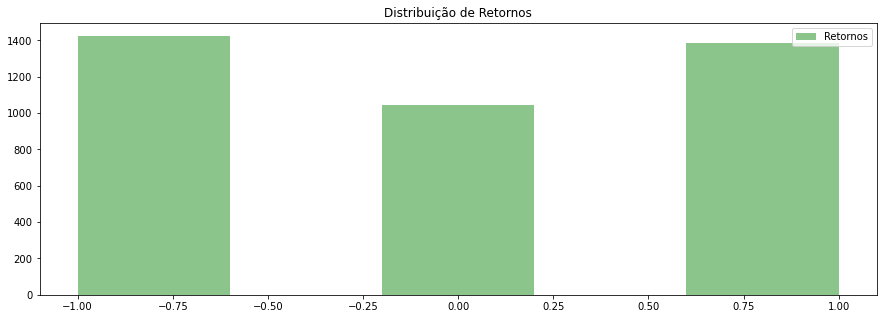

In [11]:
plt.figure(figsize = (15,5))
plt.hist(df["AlvoBin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "g"
        , edgecolor = "none"
        , label = "Retornos")

plt.legend()
plt.title("Distribuição de Retornos");

In [12]:
# Desvio Padrão de 5 dias
df["std5"] = df["Retorno"].rolling(5).std()

# Desvio Padrão de 10 dias
df["std10"] = df["Retorno"].rolling(10).std()

# Desvio Padrão de 15 dias
df["std15"] = df["Retorno"].rolling(15).std()

# Proporção do corpo do candle em relação ao range do dia
df["prop"] = (df["Fechamento"]-df["Abertura"])/(df["Maxima"]-df["Minima"])

# Direção do dia atual
df["dirD"] = np.where(df["Fechamento"] > df["Abertura"], '1', '0')

# Direção D-1
df["dirD-1"] = df["dirD"].shift(1)

# Direção D-2
df["dirD-2"] = df["dirD"].shift(2)

# Direção D-3
df["dirD-3"] = df["dirD"].shift(3)


# Média móvel de 15 dias dp5
df["MMstd5"] = df["std5"].rolling(15).mean()

# Média móvel de 15 dias dp10
df["MMstd10"] = df["std10"].rolling(15).mean()

# Média móvel de 15 dias dp15
df["MMstd15"] = df["std15"].rolling(15).mean()

# Zscore
#df["zscore"] = (df["Fechamento"]-df["MM"])/df["std15"]


# RSLstd5
df["RSLstd5"] = (df["std5"]/df["std5"].rolling(15).mean())-1
# RSLstd10
df["RSLstd10"] = (df["std10"]/df["std10"].rolling(15).mean())-1
# RSLstd15
df["RSLstd15"] = (df["std15"]/df["std15"].rolling(15).mean())-1

# Adicionando algumas variáveis físicas

p= 5

# Velocidade de P dias
df["V"] = (df["Retorno"] - df["Retorno"].shift(p))/p

# Aceleração de P dias
df["A"] = (df["V"] - df["V"].shift(p))/p

# Calculando a massa
# Força
df["M"] = df["Retorno"].rolling(p).sum()
df["F"] = df["M"]*df["A"]

# Energia cinética
df["T"] = 0.5*df["M"]*df["V"]*df["V"]

# Trabalho
# Cateto oposto
catOp = df["Retorno"].rolling(p).sum()-df["Retorno"].rolling(1).sum()
catAd = p
df["Cat"] = catOp/catAd
df = df.dropna(axis = 0)
df["W"] = df["F"]*np.cos(np.arctan(df["Cat"]))

# Energia potencial
df["K"] = catOp*df["M"]

# Torque
df["Tau"] = df["F"]*np.sin(np.arctan(df["Cat"]))

# Momentum
df["Mom"] = df["M"]*df["V"]

# Gravidade
df["G"] = df["M"]*df["Retorno"].rolling(p).sum()/(df["Retorno"].rolling(p).sum())*(df["M"]/df["Retorno"].rolling(p).sum())

In [13]:
df.head()

,Abertura,Maxima,Minima,Fechamento,Lag,Retorno,Alvo,Pontos,AlvoBin,std5,...,A,M,F,T,Cat,W,K,Tau,Mom,G
Data,,,,,,,,,,,,,,,,,,,,,
2005-06-28,2369.0,2375.0,2369.0,2374.0,2360.0,-0.002940,-0.005897,-14.0,-1,0.007640,...,0.000274,-0.004085,-0.000001,-3.144358e-09,-0.000229,-0.000001,0.000005,2.562563e-10,-0.000005,NaN
2005-06-29,2365.0,2365.0,2350.0,2360.0,2350.5,-0.005897,-0.004025,-9.5,-1,0.007206,...,-0.000768,-0.014596,0.000011,-3.225396e-08,-0.001740,0.000011,0.000127,-1.950994e-08,0.000031,NaN
2005-06-30,2346.0,2356.0,2346.0,2350.5,2371.0,-0.004025,0.008722,20.5,1,0.003145,...,-0.001223,-0.027390,0.000034,-8.966265e-08,-0.004673,0.000034,0.000640,-1.565469e-07,0.000070,NaN
2005-01-07,2357.0,2382.0,2357.0,2371.0,2392.0,0.008722,0.008857,21.0,1,0.005860,...,0.000912,-0.007907,-0.000007,-6.002671e-08,-0.003326,-0.000007,0.000131,2.398154e-08,-0.000031,NaN
2005-04-07,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,0.007240,...,0.000756,0.004716,0.000004,1.502823e-08,-0.000828,0.000004,-0.000020,-2.950982e-09,0.000012,0.004716


In [14]:
dff = df.dropna(axis = 0)

dff = dff.drop(["std5", "std10", "std15", "MMstd5", "MMstd10", "MMstd15"], axis = 1)

In [15]:
# transformando as principais variáveis em intervalos

corte = 10

dff["RSLstd5"] = pd.qcut(dff["RSLstd5"], corte, labels = False)
dff["RSLstd10"] = pd.qcut(dff["RSLstd10"], corte, labels = False)
dff["RSLstd15"] = pd.qcut(dff["RSLstd15"], corte, labels = False)
dff["V"] = pd.qcut(dff["V"], corte, labels = False)
dff["A"] = pd.qcut(dff["A"], corte, labels = False)
dff["M"] = pd.qcut(dff["M"], corte, labels = False)
dff["F"] = pd.qcut(dff["F"], corte, labels = False)
dff["T"] = pd.qcut(dff["T"], corte, labels = False)
dff["W"] = pd.qcut(dff["W"], corte, labels = False)
dff["K"] = pd.qcut(dff["K"], corte, labels = False)
dff["Tau"] = pd.qcut(dff["Tau"], corte, labels = False)
dff["Mom"] = pd.qcut(dff["Mom"], corte, labels = False)
dff["G"] = pd.qcut(dff["G"] , corte, labels = False)

In [16]:
pd.crosstab(pd.qcut(df["RSLstd5"], corte, labels = False), df["AlvoBin"])/df.shape[0]*1000

AlvoBin,-1,0,1
RSLstd5,,,
0,32.949791,29.550209,37.656904
1,38.179916,27.719665,33.995816
2,41.841004,25.889121,32.165272
3,37.133891,26.412134,36.610879
4,38.179916,26.935146,34.780335
5,36.872385,25.366109,37.656904
6,33.472803,29.811715,36.872385
7,37.133891,29.811715,32.949791
8,35.303347,26.412134,38.179916


In [17]:
pd.crosstab(pd.qcut(df["RSLstd5"], 5, labels = False), df["AlvoBin"])/df.shape[0]*100

AlvoBin,-1,0,1
RSLstd5,,,
0,7.112971,5.726987,7.165272
1,7.897490,5.230126,6.877615
2,7.505230,5.230126,7.243724
3,7.060669,5.962343,6.982218
4,7.217573,4.994770,7.792887


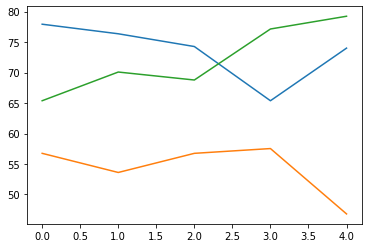

In [18]:
plt.plot(pd.crosstab(pd.qcut(df["RSLstd10"], 5, labels = False), df["AlvoBin"])/df.shape[0]*1000)

In [19]:
dff.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag', 'Retorno', 'Alvo',
       'Pontos', 'AlvoBin', 'prop', 'dirD', 'dirD-1', 'dirD-2', 'dirD-3',
       'RSLstd5', 'RSLstd10', 'RSLstd15', 'V', 'A', 'M', 'F', 'T', 'Cat', 'W',
       'K', 'Tau', 'Mom', 'G'],
      dtype='object')

In [20]:
dff = dff.drop(["M", "Cat", "Mom"], axis = 1)

# Passo 5 - Preparação da base para treinamento e teste

In [21]:
# Separando os dados entre treinamento e teste

# Treino 2005-2012
sTrain = "2005-08-07"
eTrain = "2012-12-31"
# Teste de 2020.2 até agora 
sTest = "2013-01-01"
eTest = "2020-07-16"

# dfTrain = dff[dff["Data"] <= eTrain]
# dfTest = dff[dff["Data"] > eTrain]

dfTrain = dff.loc[sTrain : eTrain]
dfTest  = dff.loc[sTest  : eTest]

In [22]:
dff3 = dff.copy()
dff4 = dff.copy()

In [23]:
dfTest.head()

,Abertura,Maxima,Minima,Fechamento,Lag,Retorno,Alvo,Pontos,AlvoBin,prop,...,RSLstd10,RSLstd15,V,A,F,T,W,K,Tau,G
Data,,,,,,,,,,,,,,,,,,,,,
2013-02-01,2041.0,2056.5,2041.0,2055.5,2057.0,-0.001700,0.000730,1.5,0,0.935484,...,3,0,4,6,2,4,2,3,6,3
2013-03-01,2057.0,2059.5,2043.5,2057.0,2043.5,0.000730,-0.006563,-13.5,-1,0.000000,...,4,0,3,3,6,3,6,5,2,2
2013-04-01,2057.5,2059.0,2041.0,2043.5,2039.0,-0.006563,-0.002202,-4.5,0,-0.777778,...,3,1,7,8,2,3,2,0,3,4
2013-07-01,2044.0,2045.5,2033.0,2039.0,2050.0,-0.002202,0.005395,11.0,1,-0.400000,...,3,1,5,4,4,4,4,1,4,4
2013-08-01,2036.5,2050.0,2029.5,2050.0,2050.0,0.005395,0.000000,0.0,0,0.658537,...,4,2,4,2,6,4,6,3,2,3


In [24]:
xTrain = dfTrain.iloc[:, 9:24]
yTrain = dfTrain["AlvoBin"].values.reshape(-1,1)

xTest = dfTest.iloc[:, 9:24]
yTest = dfTest["AlvoBin"].values.reshape(-1,1)

# Passo 6 - Treinamento do modelo

In [25]:
# Treinando o modelo

# kernels: rb, poly, linear

svm = svm.SVC(kernel = "rbf", max_iter = 2000, gamma = "auto", random_state = 42)
svm.fit(xTrain, yTrain)

SVC(gamma='auto', max_iter=2000, random_state=42)

In [26]:
predTrain = svm.predict(xTrain)
predTest = svm.predict(xTest)

In [27]:
print(confusion_matrix(yTrain, predTrain))
print()
print("------------------------------------------------")
print()
print(classification_report(yTrain,predTrain))

[[560  69  42]
 [126 372  46]
 [110  72 414]]

------------------------------------------------

              precision    recall  f1-score   support

          -1       0.70      0.83      0.76       671
           0       0.73      0.68      0.70       544
           1       0.82      0.69      0.75       596

    accuracy                           0.74      1811
   macro avg       0.75      0.74      0.74      1811
weighted avg       0.75      0.74      0.74      1811



In [28]:
print(confusion_matrix(yTest, predTest))
print()
print("------------------------------------------------")
print()
print(classification_report(yTest,predTest))

[[339 151 192]
 [219 121 124]
 [317 161 242]]

------------------------------------------------

              precision    recall  f1-score   support

          -1       0.39      0.50      0.44       682
           0       0.28      0.26      0.27       464
           1       0.43      0.34      0.38       720

    accuracy                           0.38      1866
   macro avg       0.37      0.36      0.36      1866
weighted avg       0.38      0.38      0.37      1866



In [29]:
predTot = svm.predict(dff.iloc[:,9:24])

In [30]:
dff.loc[:, "Previsto"] = predTot
dff.loc[:, "RetornoModelo"] = dff.loc[:, "Previsto"]*dff["Alvo"]

In [31]:
stop = 0.025

dff.loc[:, "RetornoModelo"] = np.where(dff.loc[:, "RetornoModelo"] < -stop, -stop, dff.loc[:, "RetornoModelo"])
dff.loc[:, "RetornoModeloAcum"] = dff["RetornoModelo"].cumsum()

In [32]:
dff.loc[:, "RetornoModeloAcum"].tail()

Data
2020-08-12    9.917466
2020-09-12    9.945499
2020-10-12    9.954052
2020-11-12    9.963321
2020-12-14    9.968792
Name: RetornoModeloAcum, dtype: float64

In [33]:
dff.index.name = "Date"
dff.reset_index(inplace = True)

dff["Date"] = pd.to_datetime(dff["Date"])
dff["trainTest"] = np.where(dff["Date"] > eTrain, 1, -1)

In [34]:
dff.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag,Retorno,Alvo,Pontos,AlvoBin,...,F,T,W,K,Tau,G,Previsto,RetornoModelo,RetornoModeloAcum,trainTest
0,2005-04-07,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,...,6,7,6,0,3,6,-1,-0.005017,-0.005017,-1
1,2005-05-07,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,...,5,7,5,4,6,7,0,0.000000,-0.005017,-1
2,2005-06-07,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,...,8,8,8,7,8,8,-1,0.007867,0.002851,-1
3,2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,...,7,6,7,7,8,8,-1,0.003339,0.006190,-1
4,2005-08-07,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,...,1,7,1,4,2,6,-1,0.012144,0.018334,-1


In [35]:
bAgreg = dff.resample("M", on = "Date").sum()
bAgreg.loc[:, "RetornoModeloAcum"] = bAgreg["RetornoModelo"].cumsum()*100

""


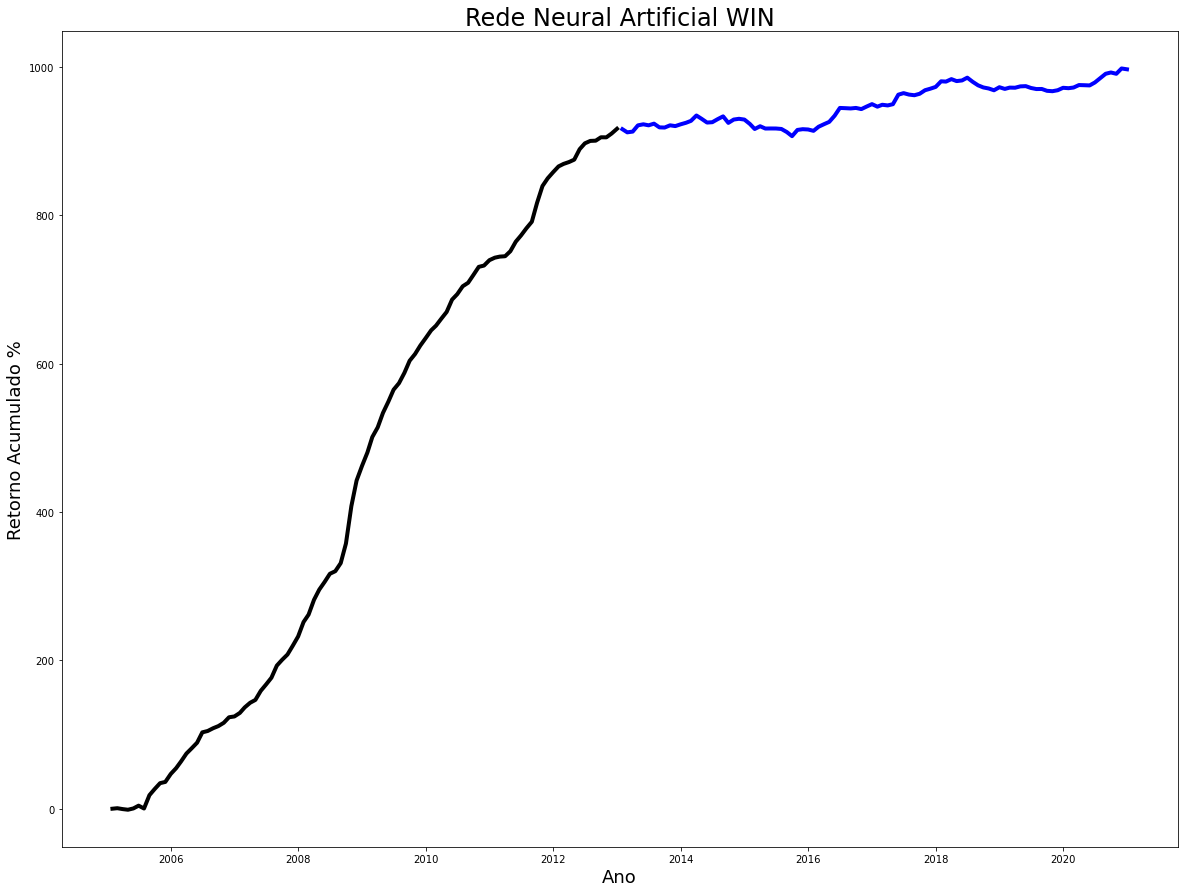

In [36]:
fig,ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["trainTest"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.RetornoModeloAcum, c = color, linewidth = lw)
    plt.xlabel("Ano", fontsize = 18)
    plt.ylabel("Retorno Acumulado %", fontsize = 18)
    plt.title("SVM WDO", fontsize = 24)
    #plt.axvline(x = eTrain, color = "purple", linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    #plt.text('2007-01-01', 500, "Treinamento 2005-2010", **setup)
    #plt.text("2012-01-01", 500, "Teste: 2011-2020", **setup)
    #plt.text("2008-06-01", 500, "ret total 587%", **setup)
    #plt.text("2008-06-01", 500, "Ret Teste 218%", **setup)
    #plt.text("2011-03-01", 500, "@daltonlbs", **setup)
    
bAgreg.groupby((bAgreg["trainTest"].shift() * bAgreg["trainTest"] < 0).cumsum()).apply(grafico)

In [40]:
svm2 = svm.SVC(kernel = "rbf")

parametros = {
    "C":np.arange(1,5,1), #1,11,1
    "max_iter" : np.arange(100,1000,100), #100,2100,100
    "gamma" : np.arange(0.01,0.7,0.1) #0.01,1.1,0.1 
}

In [41]:
scorers = {
    "accuracy_score" : make_scorer(accuracy_score)
}

In [49]:
def otimizacao (refit_score = "accuracy_score"):
    inicio = int(time.time())
    
    cv= StratifiedKFold(n_splits = 10) # Uma instância de CrossValidation com split de 10
    
    # O GridSearch vai testar as variáveis colocadas em 'parametros' e buscar o melhor conjunto
    gridSearch = GridSearchCV(svm2, parametros, scoring= scorers, refit= refit_score, 
                              cv=cv, return_train_score = True)
    gridSearch.fit(xTrain, yTrain)
    
    # Predição ba base de teste
    predTrain = gridSearch.predict(xTrain)
    predTest = gridSearch.predict(xTest)
    
    print("Melhores parametros para o {}".format(refit_score))
    print(gridSearch.best_params_)
    
    # Matriz de confusão na base de treinamento
    print("nMatriz de confusão da SVM para {} na base de treinamento:".format(refit_score))
    print(pd.DataFrame(confusion_matrix(yTrain, predTrain),
                       columns = ["predVende", "predNada", "PredCompra"], index= ["vende", "nada", "compra"]))  
    
    # Matriz de confusão na base de teste
    print("\nMatriz de confusão da SVM para {} na base de teste:".format(refit_score))
    print(pd.DataFrame(confusion_matrix(yTest, predTest),
                       columns = ["predVende", "predNada", "PredCompra"], index= ["vende", "nada", "compra"]))
    #print("Tempo de execução: %s minutos" % ((time.time() - inicio))/60)
    return gridSearch

In [50]:
otmzSVM = otimizacao(refit_score = "accuracy_score")

Melhores parametros para o accuracy_score
{'C': 2, 'gamma': 0.01, 'max_iter': 900}
nMatriz de confusão da SVM para accuracy_score na base de treinamento:
        predVende  predNada  PredCompra
vende         403       173          95
nada          193       277          74
compra        237       158         201
nMatriz de confusão da SVM para accuracy_score na base de teste:
        predVende  predNada  PredCompra
vende         342       187         153
nada          234       149          81
compra        338       214         168


In [51]:
otmzSVM

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4]),
                         'gamma': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61]),
                         'max_iter': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             refit='accuracy_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score)})

In [52]:
dfTrain3 = dff3.loc[sTrain : eTrain]
dfTest3 = dff3.loc[sTest : eTest]

svm3 = svm.SVC(kernel = "rbf", C = 2, gamma = 0.01, max_iter = 900, random_state = 42)
svm3.fit(xTrain, yTrain)

SVC(C=2, gamma=0.01, max_iter=900, random_state=42)

In [53]:
predTrain3 = svm3.predict(xTrain)
predTest3 = svm3.predict(xTest)

In [54]:
print(confusion_matrix(yTrain, predTrain3))
print()
print("------------------------------------------------")
print()
print(classification_report(yTrain,predTrain3))

[[403 173  95]
 [193 277  74]
 [237 158 201]]

------------------------------------------------

              precision    recall  f1-score   support

          -1       0.48      0.60      0.54       671
           0       0.46      0.51      0.48       544
           1       0.54      0.34      0.42       596

    accuracy                           0.49      1811
   macro avg       0.49      0.48      0.48      1811
weighted avg       0.49      0.49      0.48      1811



In [55]:
print(confusion_matrix(yTest, predTest3))
print()
print("------------------------------------------------")
print()
print(classification_report(yTest,predTest3))

[[342 187 153]
 [234 149  81]
 [338 214 168]]

------------------------------------------------

              precision    recall  f1-score   support

          -1       0.37      0.50      0.43       682
           0       0.27      0.32      0.29       464
           1       0.42      0.23      0.30       720

    accuracy                           0.35      1866
   macro avg       0.35      0.35      0.34      1866
weighted avg       0.37      0.35      0.35      1866



In [56]:
predTot3 = svm3.predict(dff3.iloc[:,9:24])

In [57]:
dff3.loc[:, "Previsto"] = predTot3
dff3.loc[:, "RetornoModelo"] = dff3.loc[:, "Previsto"]*dff3["Alvo"]

stop = 0.025

dff3.loc[:, "RetornoModelo"] = np.where(dff3.loc[:, "RetornoModelo"] < -stop, -stop, dff3.loc[:, "RetornoModelo"])
dff3.loc[:, "RetornoModeloAcum"] = dff3["RetornoModelo"].cumsum()

In [58]:
dff3["RetornoModeloAcum"].tail()

Data
2020-08-12    3.871826
2020-09-12    3.899859
2020-10-12    3.899859
2020-11-12    3.890590
2020-12-14    3.896061
Name: RetornoModeloAcum, dtype: float64

In [59]:
dff3.index.name = "Date"
dff3.reset_index(inplace = True)

dff3["Date"] = pd.to_datetime(dff3["Date"])
dff3["trainTest"] = np.where(dff3["Date"] > eTrain, 1, -1)

In [60]:
bAgreg3 = dff3.resample("M", on = "Date").sum()
bAgreg3.loc[:, "RetornoModeloAcum"] = bAgreg3["RetornoModelo"].cumsum()*100

""


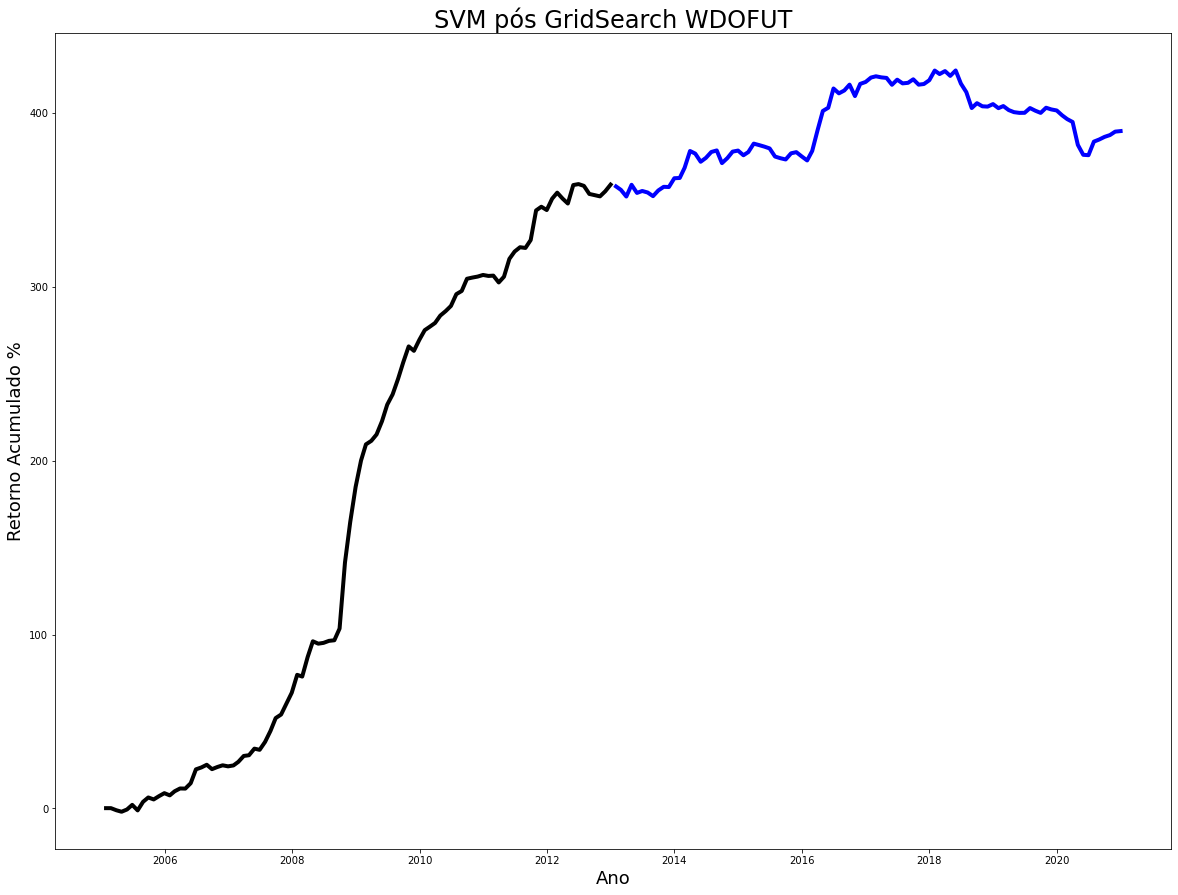

In [73]:
fig,ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["trainTest"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.RetornoModeloAcum, c = color, linewidth = lw)
    plt.xlabel("Ano", fontsize = 18)
    plt.ylabel("Retorno Acumulado %", fontsize = 18)
    plt.title("SVM pós GridSearch WDOFUT", fontsize = 24)
    #plt.axvline(x = eTrain, color = "purple", linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    #plt.text('2007-01-01', 500, "Treinamento 2005-2010", **setup)
    #plt.text("2012-01-01", 500, "Teste: 2011-2020", **setup)
    #plt.text("2008-06-01", 500, "ret total 587%", **setup)
    #plt.text("2008-06-01", 500, "Ret Teste 218%", **setup)
    #plt.text("2011-03-01", 500, "@daltonlbs", **setup)
    
bAgreg3.groupby((bAgreg3["trainTest"].shift() * bAgreg3["trainTest"] < 0).cumsum()).apply(grafico)

In [62]:
dfTrain4 = dff4.loc[sTrain : eTrain]
dfTest4 = dff4.loc[sTest : eTest]

In [63]:
prop = 0.5
propc = 1-prop

predTrain4 = (predTrain*prop + predTrain3*propc)
predTest4 = (predTest*prop + predTest3*propc)

In [64]:
predTrain4

array([-1. ,  0.5,  1. , ..., -1. ,  1. , -1. ])

In [65]:
predTrain4 = np.where(predTrain4 >= 0.5, 1, predTrain4)
predTrain4 = np.where(predTrain4 < -0.5, -1, predTrain4)
predTrain4 = np.where(((predTrain4 != -1) & (predTrain4 !=1)), 0, predTrain4)

predTest4 = np.where(predTest4 >= 0.5, 1, predTest4)
predTest4 = np.where(predTest4 < -0.5, -1, predTest4)
predTest4 = np.where(((predTest4 != -1) & (predTest4 !=1)), 0, predTest4)


In [67]:
print(confusion_matrix(yTrain, predTrain4))
print()
print("------------------------------------------------")
print()
print(classification_report(yTrain,predTrain4))

[[390 246  35]
 [ 99 376  69]
 [ 95 219 282]]

------------------------------------------------

              precision    recall  f1-score   support

          -1       0.67      0.58      0.62       671
           0       0.45      0.69      0.54       544
           1       0.73      0.47      0.57       596

    accuracy                           0.58      1811
   macro avg       0.62      0.58      0.58      1811
weighted avg       0.62      0.58      0.58      1811



In [68]:
predTot4 = (predTot*prop + predTot3*propc)

predTot4 = np.where(predTot4 >= 0.5, 1, predTot4)
predTot4 = np.where(predTot4 < -0.5, -1, predTot4)
predTot4 = np.where(((predTot4 != -1) & (predTot4 !=1)), 0, predTot4)

In [69]:
dff4.loc[:, "Previsto"] = predTot4
dff4.loc[:, "RetornoModelo"] = dff4.loc[:, "Previsto"]*dff4["Alvo"]

stop = 0.025

dff4.loc[:, "RetornoModelo"] = np.where(dff4.loc[:, "RetornoModelo"] < -stop, -stop, dff4.loc[:, "RetornoModelo"])
dff4.loc[:, "RetornoModeloAcum"] = dff4["RetornoModelo"].cumsum()

In [70]:
dff4.index.name = "Date"
dff4.reset_index(inplace = True)

dff4["Date"] = pd.to_datetime(dff4["Date"])
dff4["trainTest"] = np.where(dff4["Date"] > eTrain, 1, -1)

In [71]:
bAgreg4 = dff4.resample("M", on = "Date").sum()
bAgreg4.loc[:, "RetornoModeloAcum"] = bAgreg4["RetornoModelo"].cumsum()*100

""


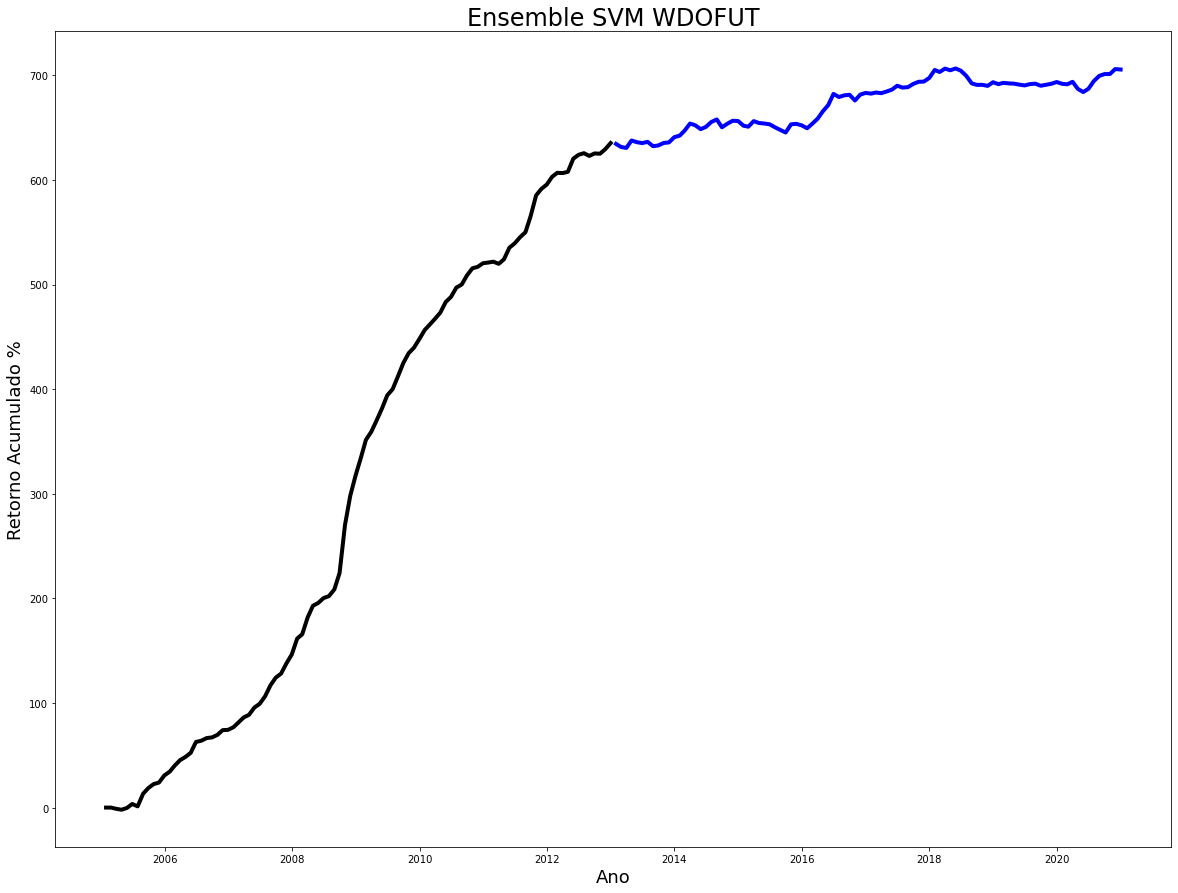

In [85]:
fig,ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["trainTest"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.RetornoModeloAcum, c = color, linewidth = lw)
    plt.xlabel("Ano", fontsize = 18)
    plt.ylabel("Retorno Acumulado %", fontsize = 18)
    plt.title("Ensemble SVM WDOFUT", fontsize = 24)
    #plt.axvline(x = eTrain, color = "purple", linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    #plt.text('2007-01-01', 500, "Treinamento 2005-2010", **setup)
    #plt.text("2012-01-01", 500, "Teste: 2011-2020", **setup)
    #plt.text("2008-06-01", 500, "ret total 587%", **setup)
    #plt.text("2008-06-01", 500, "Ret Teste 218%", **setup)
    #plt.text("2011-03-01", 500, "@daltonlbs", **setup)
    
bAgreg4.groupby((bAgreg4["trainTest"].shift() * bAgreg4["trainTest"] < 0).cumsum()).apply(grafico)

In [78]:
dfTest4.loc[: , "Previsto"] = predTest4
dfTest4.loc[: , "RetornoModelo"] = dfTest4.loc[: , "Previsto"]*dfTest4["Alvo"]

#Simulando um stop
dfTest4.loc[: , "RetornoModelo"] = np.where(dfTest4.loc[: , 'RetornoModelo'] < -stop
                                               , -stop, dfTest4.loc[: , 'RetornoModelo'])

dfTest4.loc[: , "RetornoModeloAcum"] = dfTest4["RetornoModelo"].cumsum()


In [82]:
dfTest4.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag,Retorno,Alvo,Pontos,AlvoBin,...,A,F,T,W,K,Tau,G,Previsto,RetornoModelo,RetornoModeloAcum
Date,,,,,,,,,,,,,,,,,,,,,
0,2013-02-01,2041.0,2056.5,2041.0,2055.5,2057.0,-0.001700,0.000730,1.5,0,...,6,2,4,2,3,6,3,0.0,0.000000,0.000000
1,2013-03-01,2057.0,2059.5,2043.5,2057.0,2043.5,0.000730,-0.006563,-13.5,-1,...,3,6,3,6,5,2,2,-1.0,0.006563,0.006563
2,2013-04-01,2057.5,2059.0,2041.0,2043.5,2039.0,-0.006563,-0.002202,-4.5,0,...,8,2,3,2,0,3,4,-1.0,0.002202,0.008765
3,2013-07-01,2044.0,2045.5,2033.0,2039.0,2050.0,-0.002202,0.005395,11.0,1,...,4,4,4,4,1,4,4,0.0,0.000000,0.008765
4,2013-08-01,2036.5,2050.0,2029.5,2050.0,2050.0,0.005395,0.000000,0.0,0,...,2,6,4,6,3,2,3,0.0,0.000000,0.008765


In [83]:
#dfTest4.index.name = "Date"
#dfTest4.reset_index(inplace = True)

dfTest4["Date"] = pd.to_datetime(dfTest4["Date"])
teste_agregado4 = dfTest4.resample("M", on = "Date").sum()

teste_agregado4.loc[: , "RetornoModeloAcum"] = teste_agregado4["RetornoModelo"].cumsum()*100

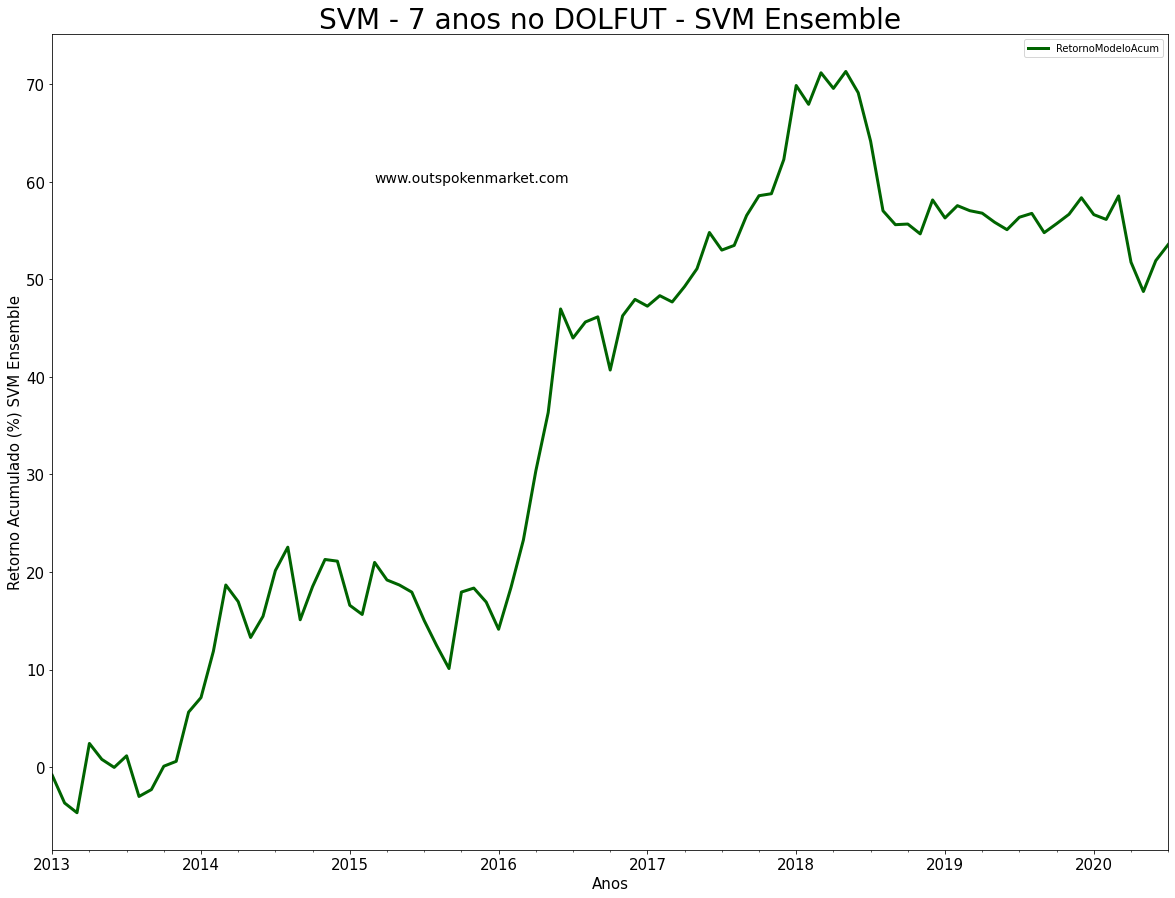

In [84]:
teste_agregado4["RetornoModeloAcum"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15
                                     , color = "darkgreen")
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado (%) SVM Ensemble"
           , fontsize = 15);
plt.title("SVM - 7 anos no DOLFUT - SVM Ensemble", fontsize = 28)
setup2 = dict(size = 14, color = "black")
plt.text("2015-03-01", 60, "www.outspokenmarket.com", **setup2)
plt.legend()
plt.show()